### Example 7 Jupyter notebook -- now with stable linear models of arbitrary order!
SINDy can discover linear models $\dot{\mathbf{x}} = \mathbf{A}\mathbf{x}$ for arbitrary state size, but these models are only long-time stable if the matrix $\mathbf{A}$ is negative definite. The new optimizer StableLinearSR3 is for precisely this case, and allows SINDy to identify much higher-dimensional models that are provably stable. In a sense we are building a-priori stable Koopman models!

Assume we have a linear library in $\mathbf x$. The optimization problem we solve is a cross between SR3 and TrappingSR3:
$$min_{\mathbf \xi, \mathbf w} \|\dot{\mathbf{X}} - \mathbf \Theta \mathbf{\xi}\|_2^2 + \frac{1}{2\nu}\|\mathbf{\xi} - \mathbf w \|_2^2,$$
such that 
$$ \mathbf C\mathbf\xi = \mathbf d, \quad \mathbf D\mathbf\xi \leq \mathbf e, \quad \lambda_\text{max}(\mathbf w) < 0,$$
where $\lambda_\text{max}(\mathbf w)$ is the largest eigenvalue of $\mathbf{w}$ and the ConstrainedSR3 and StableLinearSR3 optimizers now allow for a combination of equality and inequality constraints. Since we have a purely linear library, we can reshape $\mathbf \xi \to \mathbf{A}$ and instead write:
$$min_{\mathbf A} \|\dot{\mathbf{X}} - \mathbf A\mathbf{X}\|_2^2 + \frac{1}{2\nu}\|\mathbf{A} - \mathbf W \|_2^2,$$
such that 
$$ \mathbf C\mathbf A = \mathbf d, \quad \mathbf D\mathbf A \leq \mathbf e, \quad \lambda_\text{max}(\mathbf W) < 0.$$
This is a convenient optimization problem that can be solved for variable projection. First solve the optimization for $\mathbf{A}$ at fixed $\mathbf{W}$ (this part, including with the constraints on $\mathbf{A}$, is convex, so we can plug it right into CVXPY) and then for $\mathbf{W}$ at fixed $\mathbf{A}$, and repeat until convergence. For the $\mathbf{W}$ solve, we use the same trick as the TrappingSR3 optimizer -- $\mathbf{W}$ is a projection of $\mathbf{A}$ onto the space of negative definite matrices.

In this example, we revisit the data from the Jupyter notebook Example 7 in order to build a stable 20-dimensional linear model, which performs quite well. 

In [1]:
# Import packages
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=RuntimeWarning)
warnings.simplefilter("ignore", category=ODEintWarning)
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps

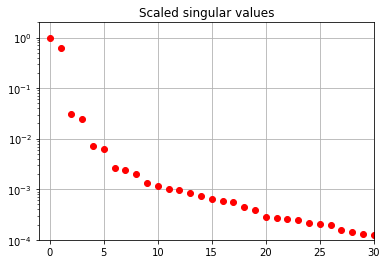

In [2]:
# Load in temporal POD modes of a plasma simulation (trajectories in time)
A = np.loadtxt("../data/plasmaphysics_example_trajectories.txt")
t = A[:, 0]
A = A[:, 1:]

# Load in the corresponding SVD data and plot it
S = np.loadtxt("../data/plasmaphysics_example_singularValues.txt")
fig, ax = plt.subplots(1, 1)
ax.semilogy(S / S[0], "ro")
ax.set(title="Scaled singular values", xlim=[-1, 30], ylim=[1e-4, 2])
ax.grid()

In [3]:
r = 20
poly_order = 2
threshold = 0.05
tfrac = 0.7  # Proportion of the data to train on

M = len(t)
M_train = int(len(t) * tfrac)
t_train = t[:M_train]
t_test = t[M_train:]

pod_names = ["a{}".format(i) for i in range(1, r + 1)]
x = A

x_train = x[:M_train, :]
x0_train = x[0, :]
x_test = x[M_train:, :]
x0_test = x[M_train, :]

# If you reduce nu, you will need more iterations 
# to make the A matrix negative definite
threshold = 0.0
sindy_opt = ps.StableLinearSR3(
    threshold=threshold,
    thresholder='l1',
    nu=1e-8,  
    max_iter=10,
    tol=1e-10,
    verbose=True,
)

In [4]:
# Pure linear library
sindy_library = ps.PolynomialLibrary(degree=1, include_bias=False)

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)

model.fit(x_train, t=t_train)
# model.print()
Xi = model.coefficients()

 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y - Xw|^2 + |w - u|^2 / v + R(u)
         0 ... 7.6981e-02 ... 2.3923e+01 ... 0.0000e+00 ... 7.6981e-02
         1 ... 7.6981e-02 ... 3.9820e-15 ... 0.0000e+00 ... 7.6981e-02
         2 ... 7.6981e-02 ... 3.9820e-15 ... 0.0000e+00 ... 7.6981e-02
         3 ... 7.6981e-02 ... 3.9823e-15 ... 0.0000e+00 ... 7.6981e-02
         4 ... 7.6981e-02 ... 3.9566e-15 ... 0.0000e+00 ... 7.6981e-02
         5 ... 7.6981e-02 ... 3.9566e-15 ... 0.0000e+00 ... 7.6981e-02
         6 ... 7.6981e-02 ... 3.9564e-15 ... 0.0000e+00 ... 7.6981e-02
         7 ... 7.6981e-02 ... 3.9818e-15 ... 0.0000e+00 ... 7.6981e-02
         8 ... 7.6981e-02 ... 3.9821e-15 ... 0.0000e+00 ... 7.6981e-02
         9 ... 7.6981e-02 ... 3.9816e-15 ... 0.0000e+00 ... 7.6981e-02


/Users/alankaptanoglu/pysindy/pysindy/optimizers/stable_linear_sr3.py:414: ConvergenceWarning: StableLinearSR3._reduce did not converge after 10 iterations.
  ConvergenceWarning,


### Make sure that eigenvalues of the final model coefficients are all negative
This is the requirement for stability! Moreover, we want to check that the imaginary part of the eigenvalues is relatively unchanged, since this would mean we mangled the fitting!

In [9]:
print(np.sort(np.linalg.eigvals(sindy_opt.coef_history[0, :])))
print(np.sort(np.linalg.eigvals(Xi.T)))
print(np.all(np.real(np.sort(np.linalg.eigvals(Xi.T))) < 0.0))

[-9.50663039e-04+0.j         -2.74113694e-04-0.00848595j
 -2.74113694e-04+0.00848595j -8.84916666e-05-0.01796237j
 -8.84916666e-05+0.01796237j -5.32119862e-05-0.50235526j
 -5.32119862e-05+0.50235526j -2.44997353e-05-0.2698913j
 -2.44997353e-05+0.2698913j  -1.17096785e-05-0.09098113j
 -1.17096785e-05+0.09098113j -6.25566513e-06-0.1811554j
 -6.25566513e-06+0.1811554j   1.27851631e-05-0.35605312j
  1.27851631e-05+0.35605312j  7.38824281e-05-0.16359833j
  7.38824281e-05+0.16359833j  1.32998144e-04-0.43957007j
  1.32998144e-04+0.43957007j  1.95208663e-04-0.09178613j
  1.95208663e-04+0.09178613j]
[-9.50663039e-04+0.j         -2.74113694e-04-0.00848595j
 -2.74113694e-04+0.00848595j -8.84916666e-05-0.01796237j
 -8.84916666e-05+0.01796237j -5.32119862e-05-0.50235526j
 -5.32119862e-05+0.50235526j -2.44997353e-05-0.2698913j
 -2.44997353e-05+0.2698913j  -1.17096785e-05-0.09098113j
 -1.17096785e-05+0.09098113j -6.25566512e-06-0.1811554j
 -6.25566512e-06+0.1811554j  -9.98195207e-11-0.35605312j
 -9.9

### Stability guarantee means we can simulate with new initial conditions no problem!

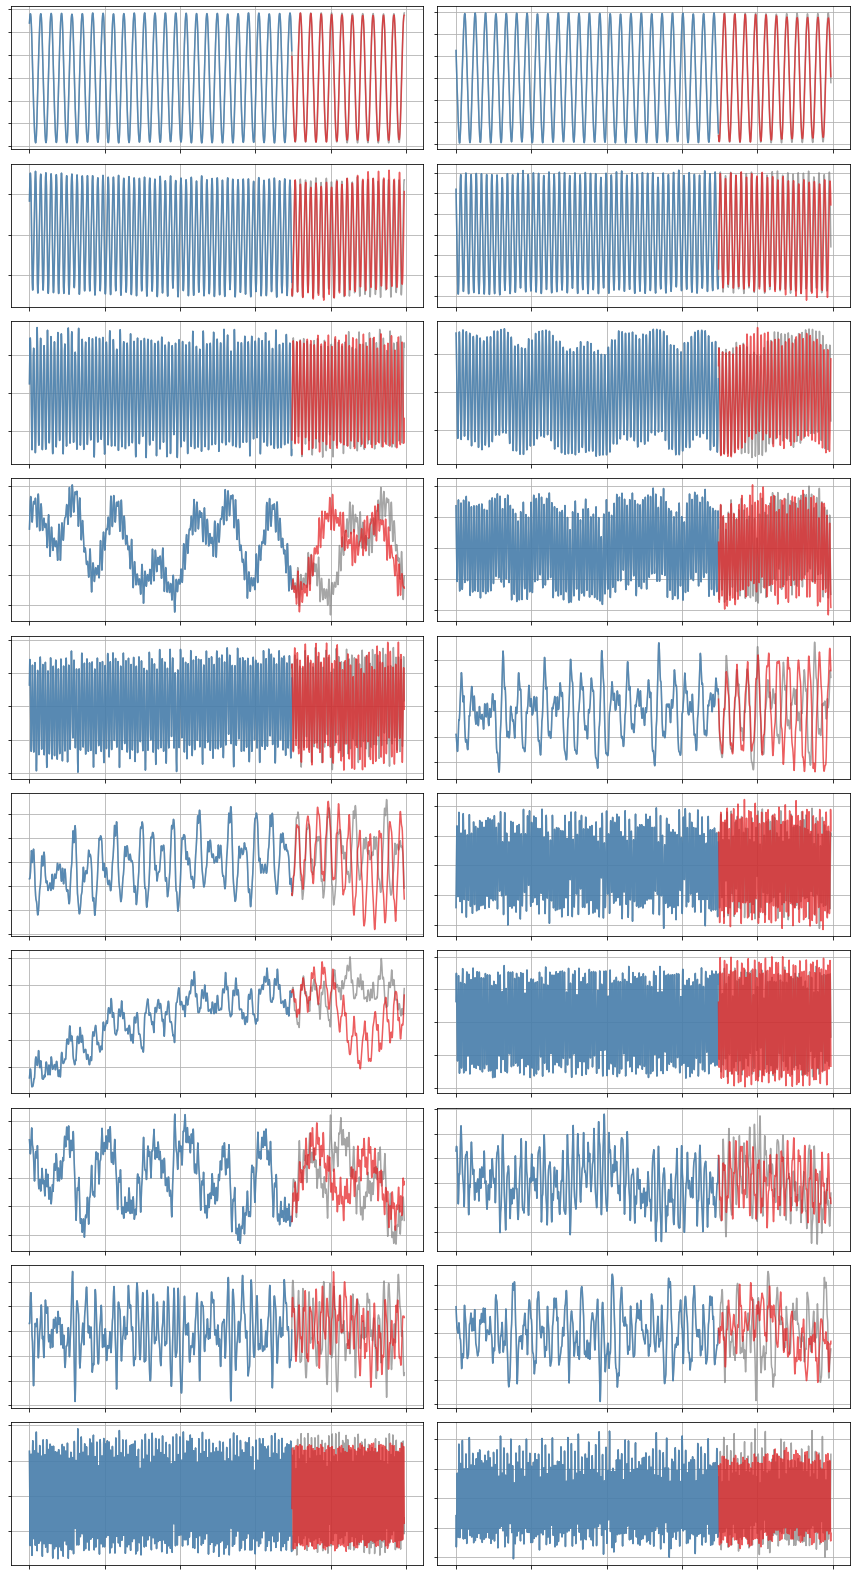

In [6]:
cmap = plt.get_cmap("Set1")

def plot_trajectories(x, x_train, x_sim, n_modes=None):
    """
    Compare x (the true data), x_train (predictions on the training data),
    and x_sim (predictions on the test data).
    """
    if n_modes is None:
        n_modes = x_sim.shape[1]

    n_rows = (n_modes + 1) // 2
    kws = dict(alpha=0.7)

    fig, axs = plt.subplots(n_rows, 2, 
                            figsize=(12, 2 * (n_rows + 1)), 
                            sharex=True)
    for i, ax in zip(range(n_modes), axs.flatten()):
        ax.plot(t, x[:, i], color="Gray", label="True", **kws)
        ax.plot(t_train, x_train[:, i], color=cmap(1), 
                label="Predicted (train)", **kws)
        ax.plot(t_test, x_sim[:, i], color=cmap(0), 
                label="Predicted (test)", **kws)

    for ax in axs.flatten():
        ax.grid(True)
        ax.set(xticklabels=[], yticklabels=[])

    fig.tight_layout()

# Forecast the testing data with this identified model
x_sim = model.simulate(x0_test, t_test)

# Compare true and simulated trajectories
plot_trajectories(x, x_train, x_sim, n_modes=r)